### Домашняя работа к Уроку 5
### Студент: Абрамов А.В.

#### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [59]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [60]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [61]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [62]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [63]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [64]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [65]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [67]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    
    final_transformers.append((cont_col, cont_transformer))


feats = FeatureUnion(final_transformers)

Объединим все это в единый пайплайн

In [68]:
# feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

#### Переходим непосредственно к моделям: 1 - бустинг, 2 - логистическая регрессия

In [78]:
# Сформируем рыбу для наполнения сводной таблицы значений метрик

#metrix = {'model':['Gradient Boosting Classifier', 'Logistic Regression'],'treshold':[], 'ROC AUC':[], 'precision':[], 'recall':[], 'F-score':[]}
metrix

{'model': ['Gradient Boosting Classifier', 'Logistic Regression'],
 'treshold': [0.4085, 0.2895],
 'ROC AUC': [0.8757, 0.7721],
 'precision': [0.7037, 0.4624],
 'recall': [0.5972, 0.5678],
 'F-score': [0.6461, 0.5097]}

In [73]:
# 1. Gradient Boosting Classifier

model_gb = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])


# обучим пайплайн на всем тренировочном датасете
model_gb.fit(X_train, y_train)

preds = model_gb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

In [77]:
metrix['treshold'].append(round(thresholds[ix], 4))
metrix['ROC AUC'].append(round(roc_auc_score(y_test, preds), 4))
metrix['precision'].append(round(precision[ix], 4))
metrix['recall'].append(round(recall[ix], 4))
metrix['F-score'].append(round(fscore[ix], 4))

In [76]:
# 2. Logistic Regression

model_lr = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])


# обучим пайплайн на всем тренировочном датасете
model_lr.fit(X_train, y_train)

preds = model_lr.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

#### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [79]:
metrix_table = pd.DataFrame(metrix)
metrix_table

,model,treshold,ROC AUC,precision,recall,F-score
0,Gradient Boosting Classifier,0.4085,0.8757,0.7037,0.5972,0.6461
1,Logistic Regression,0.2895,0.7721,0.4624,0.5678,0.5097


Gradient Boosting Classifier по метрикам F-score и ROC AUC выигрывает!

#### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты

In [80]:
# В предыдущем п. мы отобрали Gradient Boosting Classifier

preds = model_gb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

In [81]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


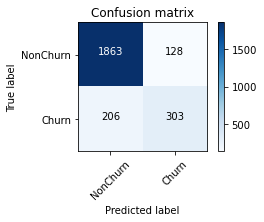

In [82]:
plt.figure(figsize=(4, 3))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [83]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

print(f'{TN=}, {FP=}, {FN=}, {TP=}')

retain_sum = (FP + TP) * 1
income = TP * 2

print(f'Расходы на привлечение: ${retain_sum}\nДоход с удержанных клиентов: ${income}\nПрибыль: ${income - retain_sum}')

TN=1863, FP=128, FN=206, TP=303
Расходы на привлечение: $431
Доход с удержанных клиентов: $606
Прибыль: $175


#### 4*. Провести подбор гиперпараметров лучшей модели по итогам пп. 2-3

In [84]:
params = {
    'classifier__max_features': [0.3, 0.5, 0.7],
    'classifier__min_samples_leaf': [1, 15, 30, 50],
    'classifier__n_estimators': [50, 100, 150, 300]
}

In [85]:
grid = GridSearchCV(model_gb,
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_features': 0.7,
 'classifier__min_samples_leaf': 30,
 'classifier__n_estimators': 300}

In [86]:
model_gb_tuned = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(n_estimators=300,
                                              min_samples_leaf=1,
                                              max_features=0.7,
                                              random_state=42)),
])


# обучим пайплайн на всем тренировочном датасете
model_gb_tuned.fit(X_train, y_train)

preds = model_gb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

In [87]:
# Посмотрим как изменилась матрица ошибок

preds = model_gb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

Confusion matrix, without normalization
[[1814  177]
 [ 184  325]]


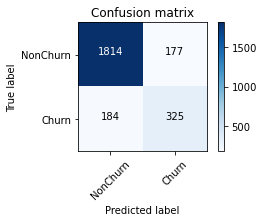

In [88]:
plt.figure(figsize=(4, 3))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### 5*. Еще раз провести оценку экономической эффективности

In [89]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

print(f'{TN=}, {FP=}, {FN=}, {TP=}')

retain_sum = (FP + TP) * 1
income = TP * 2

print(f'Расходы на привлечение: ${retain_sum}\nДоход с удержанных клиентов: ${income}\nПрибыль: ${income - retain_sum}')

TN=1814, FP=177, FN=184, TP=325
Расходы на привлечение: $502
Доход с удержанных клиентов: $650
Прибыль: $148


Хоть доход с удержанных клиентов и увеличился на $44, но расходы на привлечение выросли на $71. В итоге прибыль упала на $27